<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Adversarial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Advisorial Attacks: MNIST datasets

The reference 1 is great tutorial, but I fixed some codes issues.


Reference:
[1] https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=QMMqmdiYMkvi


In [26]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# Explain train_idx = mnist_train.targets <= 1
# if mnist_train.targets > 1, then train_idx = False; 
# if mnist_train.targets < 0, then train_idx = True; 
# Suggestion: train_idx = (mnist_train.targets <= 1)
train_idx = mnist_train.targets <= 1

mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [27]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.005211	0.015122	0.000946	0.003352
0.001500	0.005264	0.000946	0.002744
0.001342	0.004423	0.000473	0.002343
0.001184	0.003816	0.000473	0.002192
0.000869	0.003488	0.000946	0.002178
0.001026	0.003035	0.000473	0.002172
0.000947	0.003033	0.000473	0.002008
0.000947	0.002784	0.000946	0.001989
0.000711	0.002659	0.000473	0.001935
0.000869	0.002485	0.000473	0.002007


Text(0.5, 1.0, 'True Label: 0')

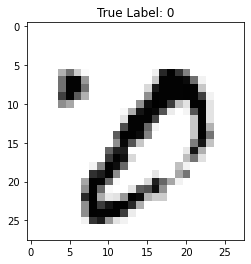

In [51]:
import matplotlib.pyplot as plt

#X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
#y_test = test_loader.dataset.test_labels

X_test = (test_loader.dataset.data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.targets

yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

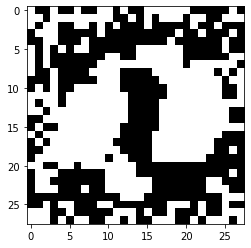

In [53]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [7]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8264775413711584, 3.4140494574328124)


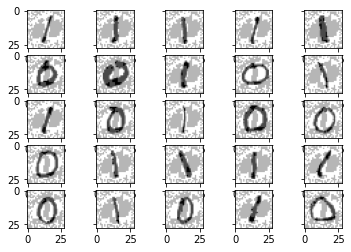

In [8]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

In [9]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [10]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.150178	0.377595	0.065248	0.215090
0.072799	0.223011	0.046809	0.168454
0.063324	0.197176	0.040662	0.153028
0.056929	0.183284	0.041608	0.145560
0.052665	0.174391	0.038298	0.135187
0.050217	0.167752	0.037352	0.130446
0.048243	0.162532	0.036407	0.127708
0.046269	0.158101	0.034043	0.130166
0.043664	0.154523	0.030733	0.117057
0.042953	0.151445	0.027896	0.117258
0.041216	0.149119	0.027423	0.117176
0.040505	0.146718	0.027423	0.109146
0.039479	0.144780	0.029314	0.119350
0.038295	0.143277	0.026478	0.111655
0.037821	0.141546	0.027423	0.113858
0.037268	0.140488	0.027423	0.110669
0.036084	0.139156	0.024586	0.100869
0.034820	0.138035	0.024113	0.103302
0.034662	0.137325	0.025059	0.101037
0.033557	0.136087	0.024586	0.101725


In [11]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.005922	0.015284	0.003310	0.008187


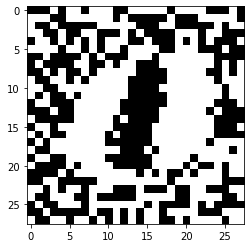

In [12]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [13]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [14]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.151046	0.380088	0.062411	0.201874
0.073983	0.223509	0.050591	0.165944
0.063877	0.197639	0.044444	0.157974
0.057086	0.183806	0.038298	0.138020
0.053139	0.175000	0.036407	0.133181
0.050138	0.168481	0.039243	0.135257
0.047769	0.163177	0.034988	0.126525
0.045795	0.158461	0.032624	0.121779
0.044295	0.154797	0.028369	0.119361
0.043190	0.151835	0.033570	0.122198
0.041848	0.149366	0.027423	0.115587
0.039716	0.146944	0.027896	0.110598
0.039005	0.145110	0.028369	0.112789
0.038373	0.143409	0.026478	0.105116
0.037268	0.141813	0.027896	0.111542
0.036952	0.140413	0.026478	0.109116
0.036478	0.139155	0.025532	0.104297
0.035294	0.138231	0.027423	0.113674
0.035294	0.137120	0.024586	0.100986
0.034505	0.136542	0.024586	0.100325


In [15]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006001	0.015228	0.003310	0.008206


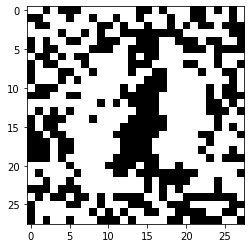

In [16]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")